**CSI 4106 Introduction to Artificial Intelligence** <br/>
*Assignment 3: Neural Networks*

# Identification

Name: Yu-Chen Lee<br/>
Student Number: 300240688

Name: Matsuru Hoshi<br/>
Student Number: 300228879



## 1. Exploratory Analysis

### Loading the dataset

A custom dataset has been created for this assignment. It has been made available on a public GitHub repository:

- [github.com/turcotte/csi4106-f24/tree/main/assignments-data/a3](https://github.com/turcotte/csi4106-f24/tree/main/assignments-data/a3)

Access and read the dataset directly from this GitHub repository in your Jupyter notebook.

You can use this code cell for you import statements and other initializations.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
import tensorflow as tf
from keras import Sequential, layers, utils
import matplotlib.pyplot as plt


In [3]:
train_url = 'https://raw.githubusercontent.com/turcotte/csi4106-f24/refs/heads/main/assignments-data/a3/cb513_train.csv'
valid_url = 'https://raw.githubusercontent.com/turcotte/csi4106-f24/refs/heads/main/assignments-data/a3/cb513_valid.csv'
test_url = 'https://raw.githubusercontent.com/turcotte/csi4106-f24/refs/heads/main/assignments-data/a3/cb513_test.csv'

train_df = pd.read_csv(train_url)
valid_df = pd.read_csv(valid_url)
test_df = pd.read_csv(test_url)

### Data Pre-Processing

2. **Shuffling the Rows**:

    - Since examples are generated by sliding a window across each protein sequence, most adjacent examples originate from the same protein and share 20 positions. To mitigate the potential negative impact on model training, the initial step involves shuffling the **rows** of the data matrix.

    In the code, **frac=1** keeps all rows while shuffling and **reset_index(drop=true)** resets the index after shuffling.

In [4]:
test_shuffled_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

train_shuffled_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

valid_shuffled_df = valid_df.sample(frac=1, random_state=42).reset_index(drop=True)

4. **Isolating the Target and the Data**:

    - In the CSV files, the target and data are combined. To prepare for our machine learning experiments, separate the training data $X$ and the target vector $y$ for each of the three datasets.

In [5]:
# training set feature-target split
X_train = train_shuffled_df.iloc[:, 1:].values # Features
y_train = train_shuffled_df.iloc[:, 0].values # Target, first column

# validation set feature-target split
X_valid = valid_shuffled_df.iloc[:, 1:].values # Features
y_valid = valid_shuffled_df.iloc[:, 0].values # Target, first column

# test set feature-target split
X_test = test_shuffled_df.iloc[:, 1:].values # Features
y_test = test_shuffled_df.iloc[:, 0].values # Target, first column

3. **Scaling of Numerical Features**:

    - Since all 462 features are proportions represented as values between 0 and 1, scaling may not be necessary. In our evaluations, using [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) actually degraded model performance. Within your pipeline, compare the effects of not scaling the data versus applying [MinMaxScaler](https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.MinMaxScaler.html). In the interest of time, a single experiment will suffice. It is important to note that when scaling is applied, a uniform method should be used across all columns, given their homogeneous nature.

    To Separate the target column from the Dataframe, we use the **iloc** method. Features (X): extracts all the columns from the second onward. Target (y) extracts the first column whose index 0 as the target.

In [6]:
# scaled pipeline
pipeline_with_scale = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

noscale_pipeline = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline_with_scale.fit(X_train,y_train)
noscale_pipeline.fit(X_train, y_train)

accuracy_no_scaling = accuracy_score(y_test, noscale_pipeline.predict(X_test))
accuracy_with_scaling = accuracy_score(y_test, pipeline_with_scale.predict(X_test))

print(f"Accuracy without scaling: {accuracy_no_scaling}")
print(f"Accuracy with MinMax scaling: {accuracy_with_scaling}")

Accuracy without scaling: 0.6742026645135244
Accuracy with MinMax scaling: 0.6742026645135244


### Model Development & Evaluation

5. **Model Development**:

    - **Dummy Model**: Implement a model utilizing the [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html). This model disregards the input data and predicts the majority class. Such model is sometimes called a straw man model.

    - **Baseline Model**: As a baseline model, select one of the previously studied machine learning algorithms: Decision Trees, K-Nearest Neighbors (KNN), or Logistic Regression. Use the default parameters provided by scikit-learn to train each model as a baseline. Why did you choose this particular classifier? Why do you think it should be appropriate for this specific task?

    - **Neural Network Model**: Utilizing [Keras](https://keras.io) and [TensorFlow](https://www.tensorflow.org), construct a sequential model comprising an input layer, a hidden layer, and an output layer. The input layer should consist of 462 nodes, reflecting the 462 attributes of each example. The hidden layer should include 8 nodes and employ the default activation function. The output layer should contain three nodes, corresponding to the three classes: helix (0), sheet (1), and coil (2). Apply the softmax activation function to the output layer to ensure that the outputs are treated as probabilities, with their sum equaling 1 for each training example.

    We therefore have three models: dummy, baseline, and neural network.

In [7]:
# dummy classifier
dummy_model = DummyClassifier(strategy='most_frequent')

# baseline model
# values taken from grid search calculated later below
baseline_model = LogisticRegression(max_iter=100, penalty='l2', tol=0.0001)

# starting neural network
nn_model = Sequential([
    layers.Dense(462, input_dim = 462),
    layers.Dense(8, activation = 'relu'),
    layers.Dense(3, activation = 'softmax')
])  
nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\leeyu\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6. **Model Evaluation**:

    - Employ cross-validation to assess the performance of the baseline model. Select a small number of folds to prevent excessive computational demands.

In [8]:
score = cross_val_score(baseline_model, X_train, y_train, cv= StratifiedKFold(n_splits=10))

In [9]:
somevalue = 30
print("="*somevalue+" Baseline Model Cross Validation "+"="*somevalue)
print("Fold  ", end=" ")
for x in range (1,11):
    print(x, end="        ")
print("")
print("Value ", end=" ")
for x in range (0,10):
    print(round(score[x], 2), end="     ")
print("")
print("="*93)

============================== Baseline Model Cross Validation ==============================
Fold   1        2        3        4        5        6        7        8        9        10        
Value  0.68     0.68     0.7     0.68     0.7     0.69     0.68     0.68     0.69     0.69     


**Training neural networks can be time-consuming.** Consequently, their performance is typically assessed once using a validation set. Make sure to not use the test set until the very end of the assignment.

In [10]:
# putting numerical values into binary array so model can train properly
y_train_categorical = utils.to_categorical(y_train)
y_valid_categorical = utils.to_categorical(y_valid)
y_test_categorical = utils.to_categorical(y_test)

In [11]:
# fitting model
nn_model.fit(X_train, y_train_categorical, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6358 - loss: 0.8277
Epoch 2/10
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6879 - loss: 0.7367
Epoch 3/10
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6970 - loss: 0.7147
Epoch 4/10
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7021 - loss: 0.7024
Epoch 5/10
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7132 - loss: 0.6869
Epoch 6/10
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7121 - loss: 0.6848
Epoch 7/10
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7174 - loss: 0.6755
Epoch 8/10
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7214 - loss: 0.6697
Epoch 9/10
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7213 - loss: 0.6657
Epoch 10/10
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7247 - loss: 0.6636


Assess the models using metrics such as precision, recall, and F1-score.

In [12]:
dummy_model.fit(X_train, y_train)
y_pred_dummy = dummy_model.predict(X_valid)

baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_valid)

nn_preds = nn_model.predict(X_valid)
y_pred_nn = np.argmax(nn_preds, axis = 1)

print("Dummy model Performance:")
print(classification_report(y_valid, y_pred_dummy))
print("Baseline model (Logistic Regression) Performance:")
print(classification_report(y_valid, y_pred_baseline))
print("Neural Network model Performance:")
print(classification_report(y_valid, y_pred_nn))

232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Dummy model Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2490
           1       0.00      0.00      0.00      1808
           2       0.42      1.00      0.59      3110

    accuracy                           0.42      7408
   macro avg       0.14      0.33      0.20      7408
weighted avg       0.18      0.42      0.25      7408

Baseline model (Logistic Regression) Performance:
              precision    recall  f1-score   support

           0       0.67      0.72      0.69      2490
           1       0.66      0.46      0.54      1808
           2       0.67      0.76      0.72      3110

    accuracy                           0.67      7408
   macro avg       0.67      0.64      0.65      7408
weighted avg       0.67      0.67      0.67      7408

Neural Network model Performance:
              precision    recall  f1-score   support

           0       0.72      0.71

C:\Users\leeyu\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\leeyu\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\leeyu\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

### Hyperparameter Optimization

7. **Baseline Model:**

    - To ensure a fair comparison for our baseline model, we will examine how varying hyperparameter values affect its performance. This prevents the erroneous conclusion that neural networks inherently perform better, when in fact, appropriate hyperparameter tuning could enhance the baseline model's performance.

    - Focus on the following relevant hyperparameters for each model:

        - [DecisionTreeClassifier](https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeClassifier.html): `criterion` and `max_depth`.
  
        - [LogisticRegression](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html): `penalty`, `max_iter`, and `tol`.
  
        - [KNeighborsClassifier](https://scikit-learn.org/dev/modules/generated/sklearn.neighbors.KNeighborsClassifier.html): `n_neighbors` and `weights`.

    - Employ a grid search strategy or utilize scikit-learn's built-in methods [GridSearchCV](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html) to thoroughly evaluate all combinations of hyperparameter values. Cross-validation should be used to assess each combination.

    - Quantify the performance of each hyperparameter configuration using precision, recall, and F1-score as metrics.

    - Analyze the findings and offer insights into which hyperparameter configurations achieved optimal performance for each model.

In [13]:
# helper function for displaying score for param combination
def gd_results(gd):
    print("Best Params: ", gd.best_params_)
    print("F1 Score: ", gd.best_score_)

# tuple with scoring metrics
    # to be used multiple times in CV and grid search
scoring_metrics = ('precision_macro', 'recall_macro', 'f1_macro')

**Decision Tree Grid Search**

In [14]:
# parameter grid for decision tree
tree_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, 20]
}

# decision tree grid search
tree_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), tree_param_grid, cv=5, scoring=scoring_metrics, return_train_score=True, refit='f1_macro')

# fitting to training data
tree_grid_search.fit(X_train, y_train);

C:\Users\leeyu\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\leeyu\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\leeyu\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

**Logistic Regression Grid Search**

In [15]:
# parameter grid for logistic regression
logic_param_grid = {
    'penalty': ['l2', None],
    'max_iter': [100, 200, 500, 10000],
    'tol': [1e-4, 1e-3, 1e-2]
}

# decision tree grid search
logic_grid_search = GridSearchCV(LogisticRegression(random_state=42), logic_param_grid, cv=5, scoring=scoring_metrics, return_train_score=True, refit='f1_macro')

# fitting to training data
logic_grid_search.fit(X_train, y_train);

**K Nearest Neighbour (KNN) Grid Search**

In [16]:
# parameter grid for KNN
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance', None]
}

# decision tree grid search
knn_grid_search = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5, scoring=scoring_metrics, return_train_score=True, refit='f1_macro')

# fitting to training data
knn_grid_search.fit(X_train, y_train);

C:\Users\leeyu\AppData\Roaming\Python\Python312\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [17]:
# show best param estimator results for each model
print("====== Baseline Models Grid Search Results =======")
print("\nDecision Tree: ")
gd_results(tree_grid_search)
print("\nLogistic Regression: ")
gd_results(logic_grid_search)
print("\nK Nearest Neighors Classifier: ")
gd_results(knn_grid_search)
print("="*50)

====== Baseline Models Grid Search Results =======

Decision Tree: 
Best Params:  {'criterion': 'entropy', 'max_depth': 10}
F1 Score:  0.521980367187025

Logistic Regression: 
Best Params:  {'max_iter': 100, 'penalty': 'l2', 'tol': 0.0001}
F1 Score:  0.6666087768284437

K Nearest Neighors Classifier: 
Best Params:  {'n_neighbors': 3, 'weights': 'distance'}
F1 Score:  0.44100492191269736


As such, we've identified the **Logistic Regression** to be better suited for the task as a baseline model, even though its score is fairly high.

8. **Neural Network:**

    In our exploration and tuning of neural networks, we focus on the following hyperparameters:

    - **Single hidden layer, varying the number of nodes**. 

        - Start with a single node in the hidden layer. Use a graph to depict the progression of loss and accuracy for both the training and validation sets, with the horizontal axis representing the number of training epochs and the vertical axis showing loss and accuracy. Training this network should be relatively fast, so let's conduct training for 50 epochs. Observing the graph, what do you conclude? Is the network underfitting or overfitting? Why?

        - Repeat the above process using 2 and 4 nodes in the hidden layer. Use the same type of graph to document your observations regarding loss and accuracy.

        - Start with 8 nodes in the hidden layer and progressively double the number of nodes until it surpasses the number of nodes in the input layer. This results in seven experiments and corresponding graphs for the following configurations: 8, 16, 32, 64, 128, 256, and 512 nodes. Document your observations throughout the process.
        
        - Ensure that the **number of training epochs** is adequate for **observing an increase in validation loss**. **Tip**: During model development, start with a small number of epochs, such as 5 or 10. Once the model appears to perform well, test with larger values, like 40 or 80 epochs, which proved reasonable in our tests. Based on your observations, consider conducting further experiments, if needed. How many epochs were ultimately necessary?

#### Models

First of all, we define the model with a single node in the hidden layer. After training the model and validing metrics. We plotted the graph based on loss and accuracy with 50 epochs

C:\Users\leeyu\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5276 - loss: 0.9580 - val_accuracy: 0.5779 - val_loss: 0.9098
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6047 - loss: 0.8778 - val_accuracy: 0.5921 - val_loss: 0.8916
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6116 - loss: 0.8716 - val_accuracy: 0.5994 - val_loss: 0.8909
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6135 - loss: 0.8679 - val_accuracy: 0.5972 - val_loss: 0.8915
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6129 - loss: 0.8685 - val_accuracy: 0.6015 - val_loss: 0.8870
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6195 - loss: 0.8626 - val_accuracy: 0.6011 - val_loss: 0.8866
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6178 - loss: 0.8663 - val_accuracy: 0.6025 - val_loss: 0.8852
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6225 - loss: 0.8598 - 

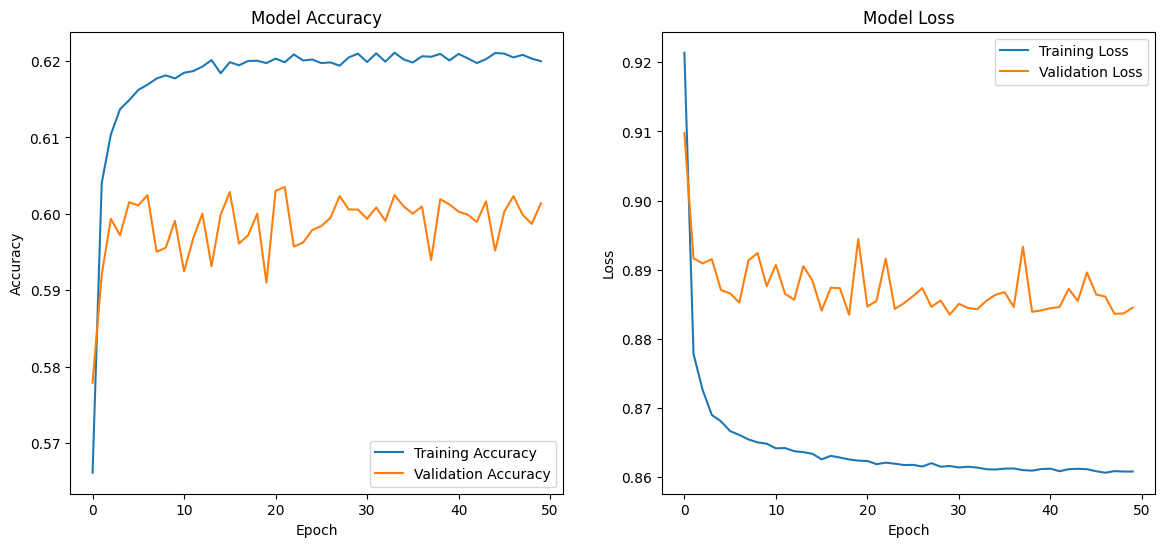

In [18]:
nn_model_single_node = Sequential([
    layers.Dense(462, input_dim = 462),
    layers.Dense(1, activation= 'relu'),
    layers.Dense(3, activation='softmax')
])

nn_model_single_node.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

history = nn_model_single_node.fit(X_train, y_train_categorical, epochs=50, batch_size=32, verbose=1, validation_data=(X_valid, y_valid_categorical))

plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


2 nodes

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5809 - loss: 0.8891 - val_accuracy: 0.6658 - val_loss: 0.7957
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6792 - loss: 0.7668 - val_accuracy: 0.6655 - val_loss: 0.7866
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6852 - loss: 0.7544 - val_accuracy: 0.6702 - val_loss: 0.7772
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6839 - loss: 0.7524 - val_accuracy: 0.6708 - val_loss: 0.7927
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6867 - loss: 0.7459 - val_accuracy: 0.6758 - val_loss: 0.7705
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6875 - loss: 0.7464 - val_accuracy: 0.6736 - val_loss: 0.7723
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6872 - loss: 0.7441 - val_accuracy: 0.6697 - val_loss: 0.7704
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6882 - loss: 0.7432 - 

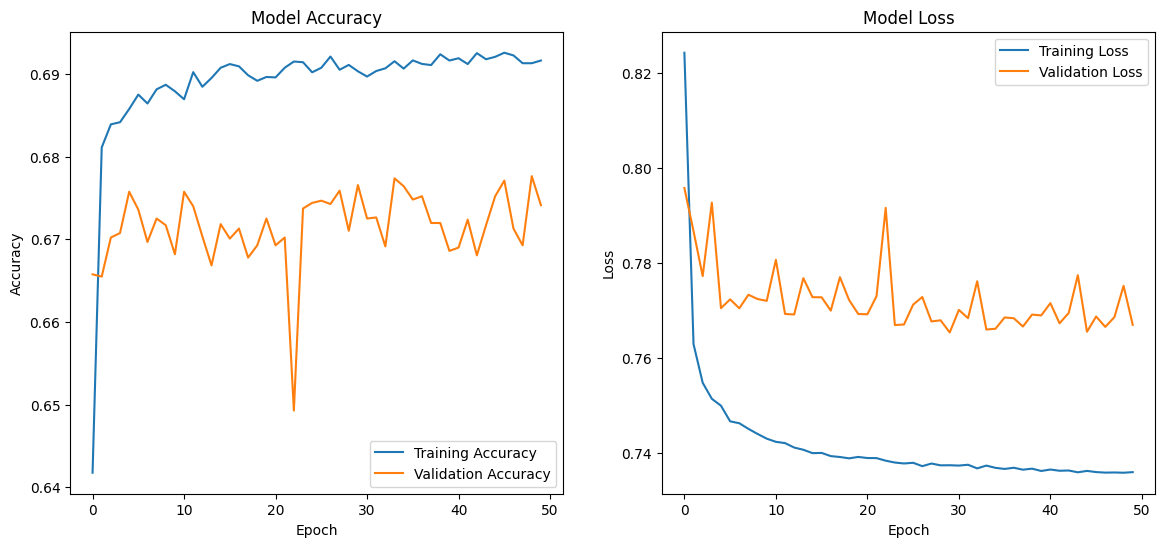

In [19]:
nn_model_two_node = Sequential([
    layers.Dense(462, input_dim = 462),
    layers.Dense(2, activation= 'relu'),
    layers.Dense(3, activation='softmax')
])

nn_model_two_node.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

history = nn_model_two_node.fit(X_train, y_train_categorical, epochs=50, batch_size=32, verbose=1, validation_data=(X_valid, y_valid_categorical))

plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


4 nodes

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5835 - loss: 0.9055 - val_accuracy: 0.6639 - val_loss: 0.7919
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6832 - loss: 0.7588 - val_accuracy: 0.6735 - val_loss: 0.7685
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6888 - loss: 0.7477 - val_accuracy: 0.6739 - val_loss: 0.7712
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6925 - loss: 0.7397 - val_accuracy: 0.6670 - val_loss: 0.7701
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6900 - loss: 0.7417 - val_accuracy: 0.6737 - val_loss: 0.7658
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6926 - loss: 0.7347 - val_accuracy: 0.6824 - val_loss: 0.7588
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6970 - loss: 0.7270 - val_accuracy: 0.6705 - val_loss: 0.7581
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6991 - loss: 0.7221 - 

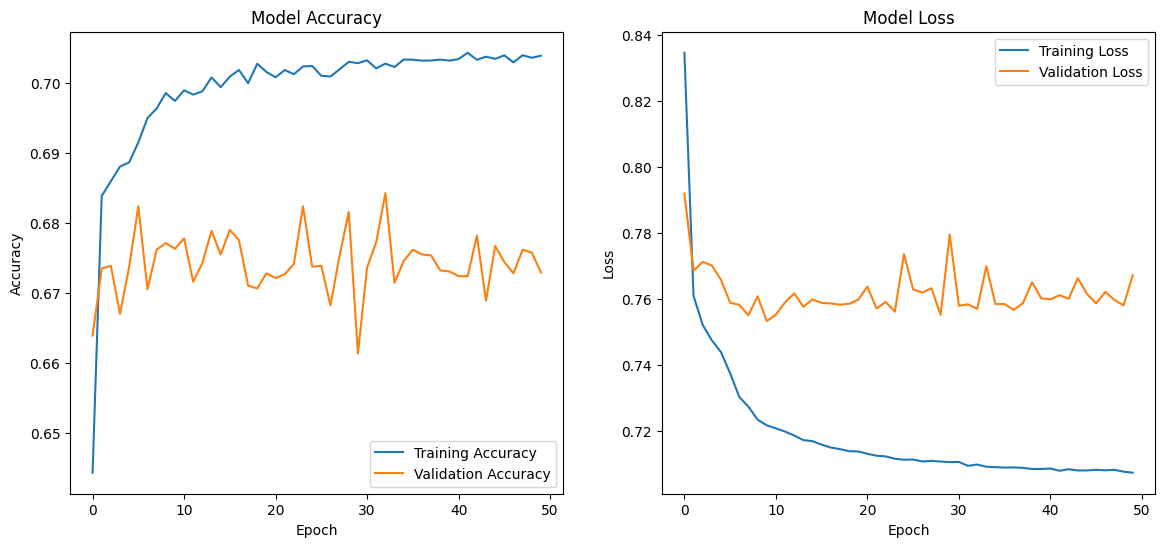

In [20]:
nn_model_4_node = Sequential([
    layers.Dense(462, input_dim = 462),
    layers.Dense(4, activation= 'relu'),
    layers.Dense(3, activation='softmax')
])

nn_model_4_node.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

history = nn_model_4_node.fit(X_train, y_train_categorical, epochs=50, batch_size=32, verbose=1, validation_data=(X_valid, y_valid_categorical))

plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


This plot shows overfitting of the model. The training accuracy steadily increases, reaching around 0.80, which suggests the model is learning and fitting the training data well.
The validation accuracy, however, peaks early around epoch 5 and then gradually declines, indicating that the model begins to overfit after this point. This decline shows that the model is not generalizing well to unseen data, as it "memorizes" the training data rather than learning patterns that generalize. The training loss consistently decreases, which aligns with the increasing training accuracy, suggesting effective learning on the training set.
The validation loss begins to increase after epoch 5, diverging from the training loss, which is a clear indication of overfitting. As the model continues training, it loses its ability to generalize, leading to a growing gap between training and validation loss.


To experiment with the double the number of the nodes in the hidden layers, we use a loop to continually compile the models with different nodes. We create a list of node counts and then train and evalute a model with each configuration. The model is trained for 50 epochs, and the training and validation accuracy and loss are stored in history_dict for plotting



Training model with 8 nodes in the hidden layer...
Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6306 - loss: 0.8303 - val_accuracy: 0.6620 - val_loss: 0.7789
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6850 - loss: 0.7400 - val_accuracy: 0.6744 - val_loss: 0.7605
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6969 - loss: 0.7243 - val_accuracy: 0.6806 - val_loss: 0.7566
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6967 - loss: 0.7118 - val_accuracy: 0.6817 - val_loss: 0.7545
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7049 - loss: 0.7013 - val_accuracy: 0.6822 - val_loss: 0.7530
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7103 - loss: 0.6916 - val_accuracy: 0.6867 - val_loss: 0.7414
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7098 - loss: 0.6859 - val_accuracy: 0.6814 - val_loss: 0.7449
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━

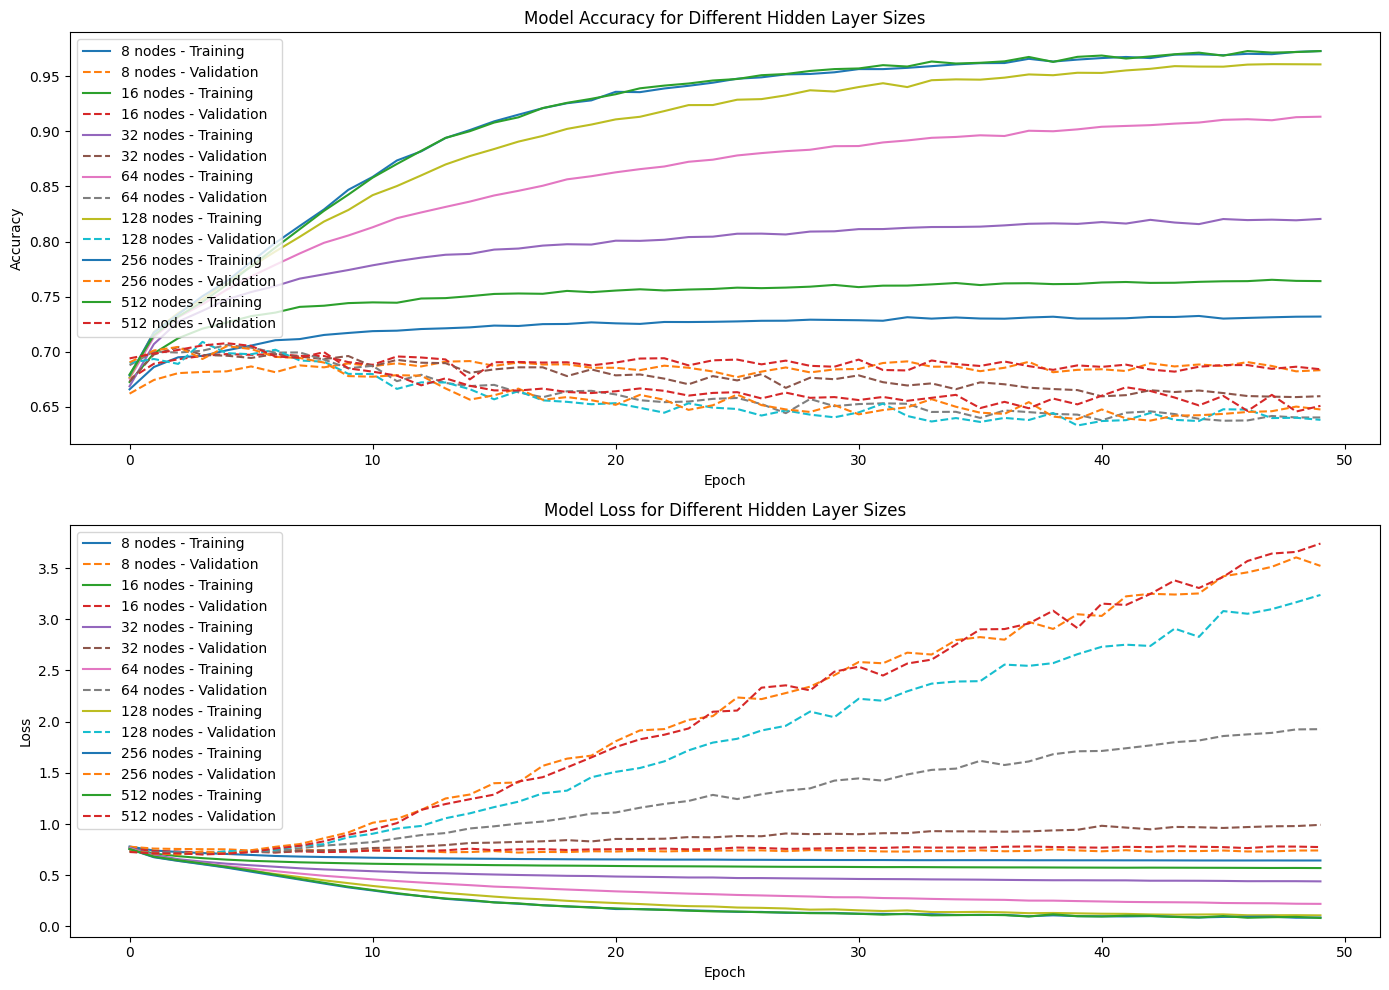

In [21]:
node_counts = [8, 16, 32, 64, 128, 256, 512]
history_dict = {}
for nodes in node_counts:
    print(f"\nTraining model with {nodes} nodes in the hidden layer...")
    nn_model_single_node = Sequential([
    layers.Dense(462, input_dim = 462),
    layers.Dense(nodes, activation= 'relu'),
    layers.Dense(3, activation='softmax')
    ])

    nn_model_single_node.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

    history = nn_model_single_node.fit(X_train, y_train_categorical, epochs=50, batch_size=32, verbose=1, validation_data=(X_valid, y_valid_categorical))

    history_dict[nodes] = history.history

plt.figure(figsize=(14,10))
plt.subplot(2, 1, 1)
for nodes in node_counts:
    plt.plot(history_dict[nodes]['accuracy'], label=f'{nodes} nodes - Training')
    plt.plot(history_dict[nodes]['val_accuracy'], linestyle='--', label=f'{nodes} nodes - Validation')
plt.title('Model Accuracy for Different Hidden Layer Sizes')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(2, 1, 2)
for nodes in node_counts:
    plt.plot(history_dict[nodes]['loss'], label=f'{nodes} nodes - Training')
    plt.plot(history_dict[nodes]['val_loss'], linestyle='--', label=f'{nodes} nodes - Validation')
plt.title('Model Loss for Different Hidden Layer Sizes')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


ANALYSIS:

After experimenting with neural networks of 8, 16, 32, 64, 128, 256, and 512 nodes, we've identified that while a greater number of nodes yields higher accuracy on the training set, it does not improve accuracy with the validation set in anywhere near the same. In fact, some node combinations worsened the performance of the model, leading to low training loss but high validation loss, thus falling into overfitting.

Indeed, while the higher number of nodes seemed to be a leading factor in overfitting, another obvious reason is excessively high number of epochs. Anything after slighly below 10 epochs leads to a rise in validation loss, as well as a decrease in validation accuracy.

From our experiments, it appears that 5-7 epochs are an ideal number, as it prevents the model from learning the noise in the data, memorizing instead of generalizing.

**Varying the number of layers**
Conduct similar experiments as described above, but this time vary the number of layers from 1 to 4. Document your findings.

How many nodes should each layer contain? Test at least two scenarios. Traditionally, a common strategy involved decreasing the number of nodes from the input layer to the output layer, often by halving, to create a pyramid-like structure. However, recent experience suggests that maintaining a constant number of nodes across all layers can perform equally well. Describe your observations. It is acceptable if both strategies yield similar performance results.

Select one your models that exemplifies overfitting. In our experiments, we easily constructed a model achieving nearly 100% accuracy on the training data, yet showing no similar improvement on the validation set. Present this neural network along with its accuracy and loss graphs. Explain the reasoning for concluding that the model is overfitting.


This function creates a model with specified number of hidden layers and number of nodes per layer 

In [22]:
def build_model(num_layers, nodes_per_layer, pyramid=False):
    model = Sequential()
    model.add(layers.Dense(462, input_dim=462, activation='relu'))
    
    # Configure layers based on the specified scenario
    if pyramid:
        nodes = nodes_per_layer  # Start with the initial number of nodes
        for _ in range(num_layers):
            model.add(layers.Dense(nodes, activation='relu'))
            nodes = max(1, nodes // 2)  # Halve the number of nodes each layer (pyramid structure)
    else:
        for _ in range(num_layers):
            model.add(layers.Dense(nodes_per_layer, activation='relu'))  # Constant nodes across layers
    
    model.add(layers.Dense(3, activation='softmax')) 
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

C:\Users\leeyu\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6388 - loss: 0.8096 - val_accuracy: 0.6915 - val_loss: 0.7221
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7344 - loss: 0.6388 - val_accuracy: 0.7056 - val_loss: 0.6893
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7922 - loss: 0.5121 - val_accuracy: 0.7061 - val_loss: 0.7135
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8562 - loss: 0.3694 - val_accuracy: 0.6982 - val_loss: 0.8208
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9140 - loss: 0.2350 - val_accuracy: 0.6762 - val_loss: 1.0060
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9459 - loss: 0.1529 - val_accuracy: 0.6754 - val_loss: 1.1870
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9649 - loss: 0.1014 - val_accuracy: 0.6639 - val_loss: 1.4141
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9723 - loss: 0.0811 - 

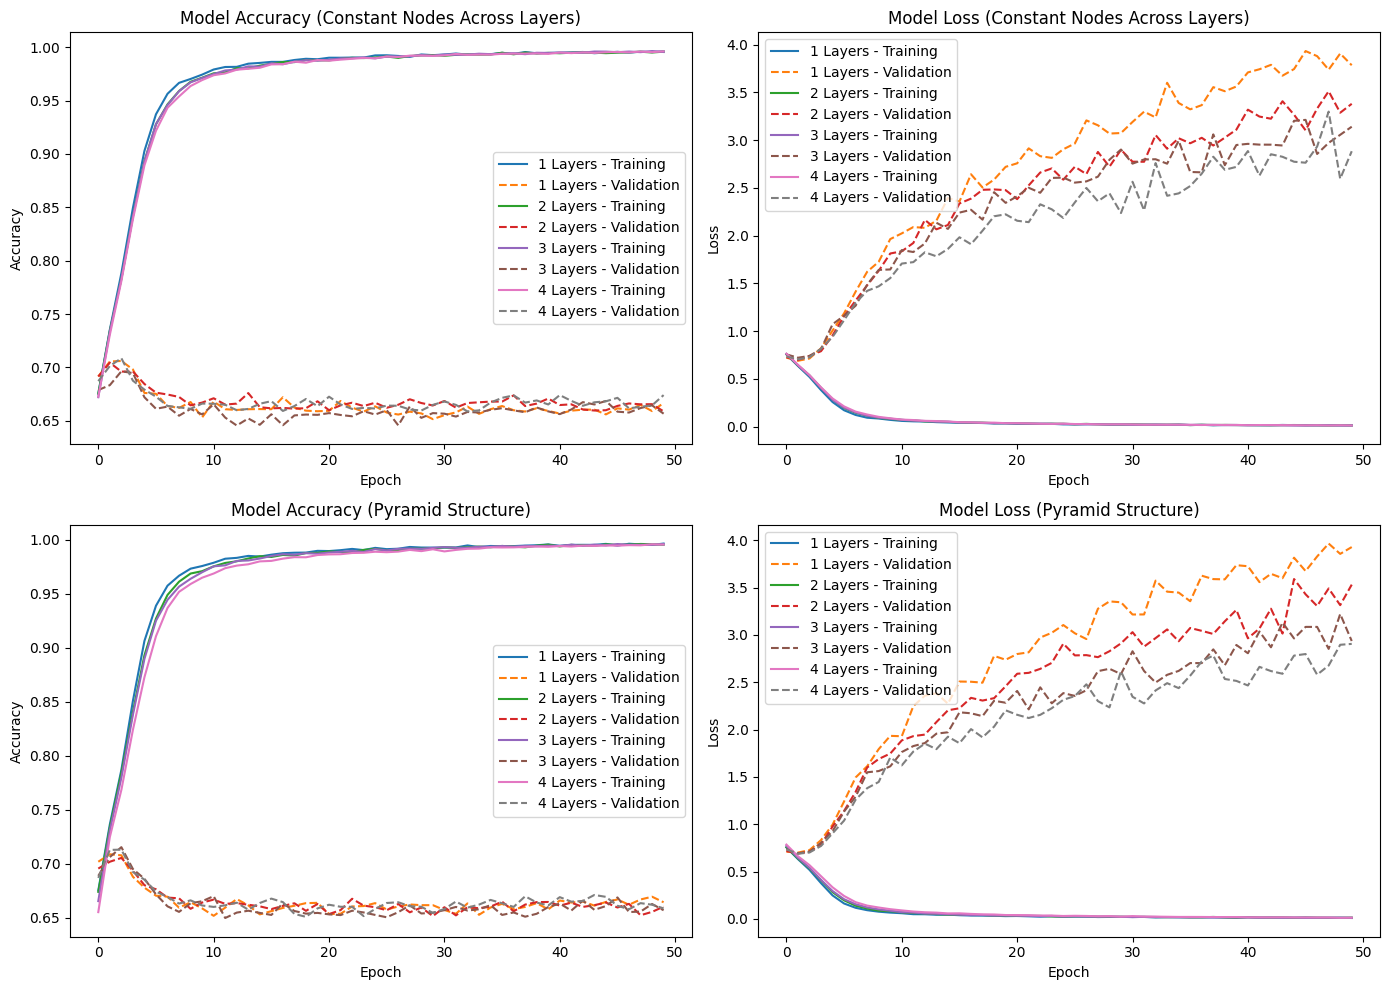

In [28]:
layer = [1, 2, 3, 4]
nodes_per_layer = 32
output_constant = []
output_pyramid = []

#constant nodes
for num_layers in layer:
    model = build_model(num_layers, nodes_per_layer, pyramid = False)
    history = model.fit(X_train, y_train_categorical, epochs=50, batch_size=32, verbose=1, validation_data=(X_valid, y_valid_categorical))
    output_constant.append(history)

#pyramid nodes structure
for num_layers in layer:
    model = build_model(num_layers, nodes_per_layer, pyramid = True)
    history = model.fit(X_train, y_train_categorical, epochs=50, batch_size=32, verbose=1, validation_data=(X_valid, y_valid_categorical))
    output_pyramid.append(history)

    
# Plot results for "Constant Nodes Across Layers"
plt.figure(figsize=(14, 10))

# Accuracy plot for Constant Nodes
plt.subplot(2, 2, 1)
for i, history in enumerate(output_constant):
    plt.plot(history.history['accuracy'], label=f"{layer[i]} Layers - Training")
    plt.plot(history.history['val_accuracy'], linestyle="--", label=f"{layer[i]} Layers - Validation")
plt.title("Model Accuracy (Constant Nodes Across Layers)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot for Constant Nodes
plt.subplot(2, 2, 2)
for i, history in enumerate(output_constant):
    plt.plot(history.history['loss'], label=f"{layer[i]} Layers - Training")
    plt.plot(history.history['val_loss'], linestyle="--", label=f"{layer[i]} Layers - Validation")
plt.title("Model Loss (Constant Nodes Across Layers)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot results for "Pyramid Structure"
# Accuracy plot for Pyramid Structure
plt.subplot(2, 2, 3)
for i, history in enumerate(output_pyramid):
    plt.plot(history.history['accuracy'], label=f"{layer[i]} Layers - Training")
    plt.plot(history.history['val_accuracy'], linestyle="--", label=f"{layer[i]} Layers - Validation")
plt.title("Model Accuracy (Pyramid Structure)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot for Pyramid Structure
plt.subplot(2, 2, 4)
for i, history in enumerate(output_pyramid):
    plt.plot(history.history['loss'], label=f"{layer[i]} Layers - Training")
    plt.plot(history.history['val_loss'], linestyle="--", label=f"{layer[i]} Layers - Validation")
plt.title("Model Loss (Pyramid Structure)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

ANALYSIS:

From our experiments, it appears that both pyramid and constant node methods **yielded similar results**. In fact, we noticed that their similarities are consistent even across the number of layers. That is to say, for both pyramid and constant node scenarios, 4 layers took as many epochs in both to reach the same accuracy or loss.

Similarly, loss similarity was even more clealry visible among the validation set, with loss decreasing as the number of layers increased. To the contrary, the training set appeared to fare better in lower loss with a lesser number of layers. This applied to both the pyramid and constant node scheme.

We have noticed no considerable improvement over the previous experiment. The neural network contines to overfit the data. We can see this since the training data reaches nearly 100% accuracy with low loss and yet the validation loss only grows. Compared to our previous single-node experiment, validation loss nearly doubles around the same 10 epochs line.

Recommendations would be to try increasing the number of layers considerably, as this appears to be correlated to lower validation loss. It's unclear however if that will help it achieve the same loss values as the training set.

**Activation function**.

Present results for one of the configurations mentioned above by varying the activation function. Test at least `relu` (the default) and `sigmoid`. The choice of the specific model, including the number of layers and nodes, is at your discretion. Document your observations accordingly.

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9790 - loss: 0.0680 - val_accuracy: 0.6585 - val_loss: 3.7388
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9781 - loss: 0.0753 - val_accuracy: 0.6467 - val_loss: 3.8487
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9783 - loss: 0.0722 - val_accuracy: 0.6552 - val_loss: 3.8693
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9782 - loss: 0.0698 - val_accuracy: 0.6563 - val_loss: 3.7702
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9788 - loss: 0.0729 - val_accuracy: 0.6604 - val_loss: 3.7987
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9770 - loss: 0.0759 - val_accuracy: 0.6515 - val_loss: 3.9896
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9789 - loss: 0.0691 - val_accuracy: 0.6427 - val_loss: 3.8017
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9785 - loss: 0.073

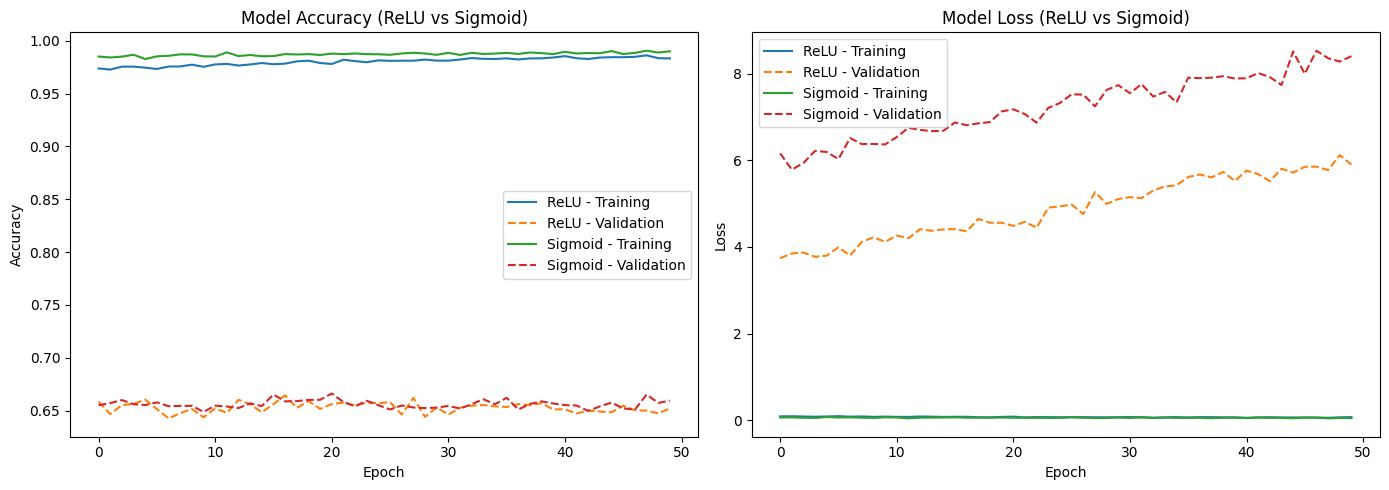

In [29]:
nodes = 16

model_relu = Sequential([
    layers.Dense(462, input_dim = 462),
    layers.Dense(nodes, activation= 'relu'),
    layers.Dense(3, activation='softmax')
    ])

model_relu.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

history_relu = nn_model_single_node.fit(X_train, y_train_categorical, epochs=50, batch_size=32, verbose=1, validation_data=(X_valid, y_valid_categorical))

model_sigmoid = Sequential([
    layers.Dense(462, input_dim = 462),
    layers.Dense(nodes, activation= 'sigmoid'),
    layers.Dense(3, activation='softmax')
    ])

model_sigmoid.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

history_sigmoid = nn_model_single_node.fit(X_train, y_train_categorical, epochs=50, batch_size=32, verbose=1, validation_data=(X_valid, y_valid_categorical))


plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_relu.history['accuracy'], label='ReLU - Training')
plt.plot(history_relu.history['val_accuracy'], linestyle="--", label='ReLU - Validation')
plt.plot(history_sigmoid.history['accuracy'], label='Sigmoid - Training')
plt.plot(history_sigmoid.history['val_accuracy'], linestyle="--", label='Sigmoid - Validation')
plt.title("Model Accuracy (ReLU vs Sigmoid)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_relu.history['loss'], label='ReLU - Training')
plt.plot(history_relu.history['val_loss'], linestyle="--", label='ReLU - Validation')
plt.plot(history_sigmoid.history['loss'], label='Sigmoid - Training')
plt.plot(history_sigmoid.history['val_loss'], linestyle="--", label='Sigmoid - Validation')
plt.title("Model Loss (ReLU vs Sigmoid)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

ANALYSIS:

The models graphed above used one layer of 16 nodes.

From our results, it appears both the ReLU and Sigmoid activation functions have their quirks. On training, Sigmoid tends to have slighly higher accuracy, something which is also seen in the validation. However, it had 50% higher loss compared to the ReLU in the validation loss. That said, both loss values were not great. For the training set, the difference in loss is minimal and both achieve good results.

What is most peculiar about this experiment is that it does not ressemble the graphs from previous experiments as much as we would imagine. There appears to be no increase or slope in either the validation accuracy or in the training loss, something which we see in the previous experiments. 

**Regularization** in neural networks is a technique used to prevent overfitting.

One technique involves adding a penalty to the loss function to discourage excessively complex models. Apply an `l2` penalty to some or all layers. Exercise caution, as overly aggressive penalties have been problematic in our experiments. Begin with the default `l2` value of 0.01, then reduce it to 0.001 and 1e-4. Select a specific model from the above experiments and present a case where you successfully reduced overfitting. Include a pair of graphs comparing results with and without regularization. Explain your rationale to conclude that overfitting has been reduced. Do not expect to completely eliminate overfitting. Again, this is a challenging dataset to work with.

In [24]:
# Code cell

Dropout layers are a regularization technique in neural networks where a random subset of neurons is temporarily removed during training. This helps prevent overfitting by promoting redundancy and improving the network's ability to generalize to new data. Select a specific model from the above experiments where you have muliple layers and experiment adding one or of few dropout layers into your network. Experiment with two different rates, say 0.25 and 0.5. Document your observations.

In [25]:
# Code cell

Summarize your experiments with using a graphical representation such as Figure 6.15 [on this page](https://egallic.fr/Enseignement/ML/ECB/book/deep-learning.html).

In [26]:
# Code cell

Early stopping is a regularization technique in neural network training wherein the process is halted when validation set performance starts to decline, thus preventing overfitting by avoiding the learning of noise in the training data. From all the experiments conducted thus far, choose **one** configuration (the number of layers, number of nodes, activation function, L2 penalty, and dropout layers) that yielded the best performance. Use a graph of loss and accuracy to determine the optimal number of training iterations for this network. What is the optimal number of epochs for this network configuration and why?

In [27]:
# Code cell

### Test

9. **Model Comparison**:

    - Evaluate the baseline model on the test set, using the optimal parameter set identified through grid search. Additionally, apply your best-performing neural network configuration to the test set.

    - Quantify the performance of the baseline model (best hyperparameter configuration) and your neural network (best configuration) using precision, recall, and F1-score as metrics. How do these two models compare to the dummy model?

    - Provide recommendations on which model(s) to choose for this task and justify your choices based on the analysis results.

In [28]:
# Code cell

# Resources